In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import tqdm
import copy
from tinyyolov2NoBN import TinyYoloV2NoBN
from pruned_tinyyolov2NoBN import PrunedTinyYoloV2NoBN 
from typing import Dict, List

from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes
from utils.loss import YoloLoss

from utils.dataloader import VOCDataLoaderPerson

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
loader = VOCDataLoaderPerson(train=True, batch_size=32, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True)

In [3]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    for name, param in state_dict.items():
        # Only prune conv layers, excluding conv1 and conv9
        if 'conv' in name and 'weight' in name and 'conv1' not in name and 'conv9' not in name:
            weight = state_dict[name]
            out_channels = weight.shape[0]
            num_channels_to_prune = int(out_channels*prune_ratio)
            if num_channels_to_prune < 1:
                continue
            l1 = torch.sum(torch.abs(weight), (1, 2, 3))
            zero_out_channels = torch.argsort(l1)
            
            for i in range(num_channels_to_prune):
                weight[zero_out_channels[i], :, :, :] = 0
            
            state_dict[name] = weight
            
            bias_key = name.replace('weight', 'bias')
            bias = state_dict[bias_key]
            for i in range(num_channels_to_prune):
                bias[zero_out_channels[i]] = 0
            
            state_dict[bias_key] = bias
            
    return state_dict

In [4]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    mask = None
    
    for layer in range(1, 10):
        l = "conv" + str(layer) + "."
        w = l + "weight"
        b = l + "bias"
        
        weights = state_dict[w]
        biases = state_dict[b]
        if mask is not None:
            weights = weights[:,mask,:,:]
            
        mask = torch.nonzero(weights.sum(dim=[1,2,3]), as_tuple=True)[0].tolist()
        
        weights = weights[mask,:,:,:]
        biases = biases[mask]
        
        state_dict[w] = weights
        state_dict[b] = biases
    
    #weights = state_dict["fc.weight"]
    
    #fcmask = []
    #for channel in mask:
    #    for i in range(4):
    #        fcmask.append(channel * 4 + i)
    
    #state_dict["fc.weight"] = weights[:,fcmask]
    
    return state_dict

In [5]:
net = PrunedTinyYoloV2NoBN(num_classes=1)
state_dict = torch.load("fusedyolov2_0717.pt", map_location=device)
net.load_state_dict(state_dict, strict=False)
net.to(device)

frozedLayers = []
lr = 0.001
weight_decay = 0.005

criterion = YoloLoss(anchors=net.anchors)


for key, param in net.named_parameters():
    if any(x in key for x in frozedLayers):
        param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=lr, weight_decay=weight_decay)

-----Pruning iteration 1/20-----
Pruning done.
Training started.


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([32, 30, 10, 10])


  1%|▏         | 1/67 [01:23<1:31:19, 83.02s/it]

torch.Size([32, 30, 10, 10])


  3%|▎         | 2/67 [03:09<1:44:56, 96.87s/it]

torch.Size([32, 30, 10, 10])


  4%|▍         | 3/67 [04:55<1:47:42, 100.98s/it]

torch.Size([32, 30, 10, 10])


  6%|▌         | 4/67 [06:40<1:47:49, 102.69s/it]

torch.Size([32, 30, 10, 10])


  7%|▋         | 5/67 [08:30<1:48:52, 105.36s/it]

torch.Size([32, 30, 10, 10])


  9%|▉         | 6/67 [10:15<1:46:57, 105.21s/it]

torch.Size([32, 30, 10, 10])


 10%|█         | 7/67 [11:58<1:44:28, 104.48s/it]

torch.Size([32, 30, 10, 10])


 12%|█▏        | 8/67 [13:51<1:45:23, 107.17s/it]

torch.Size([32, 30, 10, 10])


 13%|█▎        | 9/67 [15:37<1:43:16, 106.84s/it]

torch.Size([32, 30, 10, 10])


 15%|█▍        | 10/67 [17:27<1:42:25, 107.81s/it]

torch.Size([32, 30, 10, 10])


 16%|█▋        | 11/67 [19:12<1:39:39, 106.77s/it]

torch.Size([32, 30, 10, 10])


 18%|█▊        | 12/67 [21:05<1:39:36, 108.66s/it]

torch.Size([32, 30, 10, 10])


 19%|█▉        | 13/67 [22:55<1:38:22, 109.31s/it]

torch.Size([32, 30, 10, 10])


 21%|██        | 14/67 [24:49<1:37:39, 110.55s/it]

torch.Size([32, 30, 10, 10])


 22%|██▏       | 15/67 [26:35<1:34:45, 109.34s/it]

torch.Size([32, 30, 10, 10])


 24%|██▍       | 16/67 [28:24<1:32:45, 109.12s/it]

torch.Size([32, 30, 10, 10])


 25%|██▌       | 17/67 [30:05<1:28:56, 106.73s/it]

torch.Size([32, 30, 10, 10])


 27%|██▋       | 18/67 [32:05<1:30:26, 110.75s/it]

torch.Size([32, 30, 10, 10])


 28%|██▊       | 19/67 [33:57<1:28:43, 110.92s/it]

torch.Size([32, 30, 10, 10])


 30%|██▉       | 20/67 [35:52<1:27:50, 112.13s/it]

torch.Size([32, 30, 10, 10])


 31%|███▏      | 21/67 [37:45<1:26:16, 112.52s/it]

torch.Size([32, 30, 10, 10])


 33%|███▎      | 22/67 [39:39<1:24:37, 112.84s/it]

torch.Size([32, 30, 10, 10])


 34%|███▍      | 23/67 [41:29<1:22:09, 112.04s/it]

torch.Size([32, 30, 10, 10])


 36%|███▌      | 24/67 [43:18<1:19:40, 111.18s/it]

torch.Size([32, 30, 10, 10])


 37%|███▋      | 25/67 [45:05<1:16:57, 109.93s/it]

torch.Size([32, 30, 10, 10])


 39%|███▉      | 26/67 [47:00<1:16:11, 111.50s/it]

torch.Size([32, 30, 10, 10])


 40%|████      | 27/67 [48:57<1:15:25, 113.14s/it]

torch.Size([32, 30, 10, 10])


 42%|████▏     | 28/67 [50:48<1:13:04, 112.43s/it]

torch.Size([32, 30, 10, 10])


 43%|████▎     | 29/67 [52:31<1:09:27, 109.67s/it]

torch.Size([32, 30, 10, 10])


 45%|████▍     | 30/67 [54:24<1:08:16, 110.72s/it]

torch.Size([32, 30, 10, 10])


 46%|████▋     | 31/67 [56:19<1:07:03, 111.77s/it]

torch.Size([32, 30, 10, 10])


 48%|████▊     | 32/67 [58:12<1:05:25, 112.15s/it]

torch.Size([32, 30, 10, 10])


 49%|████▉     | 33/67 [1:00:00<1:02:57, 111.10s/it]

torch.Size([32, 30, 10, 10])


 51%|█████     | 34/67 [1:01:54<1:01:30, 111.83s/it]

torch.Size([32, 30, 10, 10])


 52%|█████▏    | 35/67 [1:03:51<1:00:34, 113.57s/it]

torch.Size([32, 30, 10, 10])


 54%|█████▎    | 36/67 [1:05:56<1:00:22, 116.85s/it]

torch.Size([32, 30, 10, 10])


 55%|█████▌    | 37/67 [1:08:18<1:02:13, 124.46s/it]

torch.Size([32, 30, 10, 10])


 57%|█████▋    | 38/67 [1:10:32<1:01:32, 127.33s/it]

torch.Size([32, 30, 10, 10])


 58%|█████▊    | 39/67 [1:12:31<58:12, 124.72s/it]  

torch.Size([32, 30, 10, 10])


 60%|█████▉    | 40/67 [1:14:32<55:41, 123.76s/it]

torch.Size([32, 30, 10, 10])


 61%|██████    | 41/67 [1:16:41<54:17, 125.30s/it]

torch.Size([32, 30, 10, 10])


 63%|██████▎   | 42/67 [1:18:46<52:05, 125.04s/it]

torch.Size([32, 30, 10, 10])


 64%|██████▍   | 43/67 [1:20:52<50:09, 125.41s/it]

torch.Size([32, 30, 10, 10])


 66%|██████▌   | 44/67 [1:23:01<48:27, 126.42s/it]

torch.Size([32, 30, 10, 10])


 67%|██████▋   | 45/67 [1:24:57<45:15, 123.44s/it]

torch.Size([32, 30, 10, 10])


 69%|██████▊   | 46/67 [1:26:56<42:43, 122.05s/it]

torch.Size([32, 30, 10, 10])


 70%|███████   | 47/67 [1:29:04<41:20, 124.00s/it]

torch.Size([32, 30, 10, 10])


 72%|███████▏  | 48/67 [1:31:03<38:46, 122.45s/it]

torch.Size([32, 30, 10, 10])


 73%|███████▎  | 49/67 [1:33:01<36:18, 121.02s/it]

torch.Size([32, 30, 10, 10])


 75%|███████▍  | 50/67 [1:35:07<34:41, 122.46s/it]

torch.Size([32, 30, 10, 10])


 76%|███████▌  | 51/67 [1:37:15<33:07, 124.21s/it]

torch.Size([32, 30, 10, 10])


 78%|███████▊  | 52/67 [1:39:24<31:26, 125.75s/it]

torch.Size([32, 30, 10, 10])


 79%|███████▉  | 53/67 [1:41:31<29:22, 125.86s/it]

torch.Size([32, 30, 10, 10])


 81%|████████  | 54/67 [1:43:39<27:26, 126.65s/it]

torch.Size([32, 30, 10, 10])


 82%|████████▏ | 55/67 [1:45:44<25:14, 126.20s/it]

torch.Size([32, 30, 10, 10])


 84%|████████▎ | 56/67 [1:47:45<22:51, 124.66s/it]

torch.Size([32, 30, 10, 10])


 85%|████████▌ | 57/67 [1:49:51<20:49, 124.95s/it]

torch.Size([32, 30, 10, 10])


 87%|████████▋ | 58/67 [1:52:04<19:05, 127.32s/it]

torch.Size([32, 30, 10, 10])


 88%|████████▊ | 59/67 [1:54:06<16:45, 125.68s/it]

torch.Size([32, 30, 10, 10])


 90%|████████▉ | 60/67 [1:56:09<14:35, 125.06s/it]

torch.Size([32, 30, 10, 10])


 91%|█████████ | 61/67 [1:58:06<12:15, 122.53s/it]

torch.Size([32, 30, 10, 10])


 93%|█████████▎| 62/67 [2:00:17<10:26, 125.20s/it]

torch.Size([32, 30, 10, 10])


 94%|█████████▍| 63/67 [2:02:29<08:28, 127.07s/it]

torch.Size([32, 30, 10, 10])


 96%|█████████▌| 64/67 [2:04:28<06:14, 124.80s/it]

torch.Size([32, 30, 10, 10])


 97%|█████████▋| 65/67 [2:06:35<04:10, 125.26s/it]

torch.Size([32, 30, 10, 10])


 99%|█████████▊| 66/67 [2:08:42<02:05, 125.93s/it]

torch.Size([30, 30, 10, 10])


100%|██████████| 67/67 [2:10:53<00:00, 117.22s/it]


Validation started.


100%|██████████| 30/30 [01:32<00:00,  3.10s/it]


average precision [0.09114691086717634]


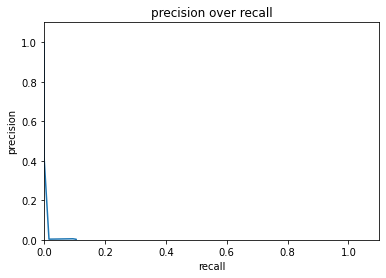

Training started.


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([32, 30, 10, 10])


  1%|▏         | 1/67 [02:06<2:19:08, 126.50s/it]

torch.Size([32, 30, 10, 10])


  3%|▎         | 2/67 [04:07<2:13:32, 123.27s/it]

torch.Size([32, 30, 10, 10])


  4%|▍         | 3/67 [06:26<2:19:00, 130.32s/it]

torch.Size([32, 30, 10, 10])


  6%|▌         | 4/67 [08:28<2:13:31, 127.17s/it]

torch.Size([32, 30, 10, 10])


  7%|▋         | 5/67 [10:30<2:09:30, 125.33s/it]

torch.Size([32, 30, 10, 10])


  9%|▉         | 6/67 [12:37<2:07:47, 125.69s/it]

torch.Size([32, 30, 10, 10])


 10%|█         | 7/67 [14:35<2:03:11, 123.19s/it]

torch.Size([32, 30, 10, 10])


 12%|█▏        | 8/67 [16:40<2:01:42, 123.77s/it]

torch.Size([32, 30, 10, 10])


 13%|█▎        | 9/67 [18:42<1:59:15, 123.37s/it]

torch.Size([32, 30, 10, 10])


 15%|█▍        | 10/67 [20:52<1:59:09, 125.44s/it]

torch.Size([32, 30, 10, 10])


 16%|█▋        | 11/67 [22:55<1:56:14, 124.54s/it]

torch.Size([32, 30, 10, 10])


 18%|█▊        | 12/67 [24:50<1:51:29, 121.63s/it]

torch.Size([32, 30, 10, 10])


 19%|█▉        | 13/67 [26:54<1:50:10, 122.42s/it]

torch.Size([32, 30, 10, 10])


 21%|██        | 14/67 [29:04<1:50:05, 124.64s/it]

torch.Size([32, 30, 10, 10])


 22%|██▏       | 15/67 [31:06<1:47:23, 123.92s/it]

torch.Size([32, 30, 10, 10])


 24%|██▍       | 16/67 [33:10<1:45:28, 124.09s/it]

torch.Size([32, 30, 10, 10])


 25%|██▌       | 17/67 [35:16<1:43:46, 124.53s/it]

torch.Size([32, 30, 10, 10])


 27%|██▋       | 18/67 [37:25<1:42:45, 125.83s/it]

torch.Size([32, 30, 10, 10])


 28%|██▊       | 19/67 [39:41<1:43:06, 128.89s/it]

torch.Size([32, 30, 10, 10])


 30%|██▉       | 20/67 [41:50<1:40:57, 128.88s/it]

torch.Size([32, 30, 10, 10])


 31%|███▏      | 21/67 [43:58<1:38:41, 128.73s/it]

torch.Size([32, 30, 10, 10])


 33%|███▎      | 22/67 [46:08<1:36:44, 128.99s/it]

torch.Size([32, 30, 10, 10])


 34%|███▍      | 23/67 [48:13<1:33:41, 127.76s/it]

torch.Size([32, 30, 10, 10])


 36%|███▌      | 24/67 [50:07<1:28:41, 123.75s/it]

torch.Size([32, 30, 10, 10])


 37%|███▋      | 25/67 [52:08<1:26:02, 122.91s/it]

torch.Size([32, 30, 10, 10])


 39%|███▉      | 26/67 [54:10<1:23:52, 122.73s/it]

torch.Size([32, 30, 10, 10])


 40%|████      | 27/67 [56:25<1:24:10, 126.27s/it]

torch.Size([32, 30, 10, 10])


 42%|████▏     | 28/67 [58:26<1:21:08, 124.84s/it]

torch.Size([32, 30, 10, 10])


 43%|████▎     | 29/67 [1:00:31<1:19:01, 124.77s/it]

torch.Size([32, 30, 10, 10])


 45%|████▍     | 30/67 [1:02:34<1:16:43, 124.43s/it]

torch.Size([32, 30, 10, 10])


 46%|████▋     | 31/67 [1:04:39<1:14:40, 124.45s/it]

torch.Size([32, 30, 10, 10])


 48%|████▊     | 32/67 [1:06:53<1:14:20, 127.43s/it]

torch.Size([32, 30, 10, 10])


 49%|████▉     | 33/67 [1:09:08<1:13:30, 129.73s/it]

torch.Size([32, 30, 10, 10])


 51%|█████     | 34/67 [1:11:14<1:10:39, 128.48s/it]

torch.Size([32, 30, 10, 10])


 52%|█████▏    | 35/67 [1:13:22<1:08:25, 128.29s/it]

torch.Size([32, 30, 10, 10])


 54%|█████▎    | 36/67 [1:15:26<1:05:40, 127.11s/it]

torch.Size([32, 30, 10, 10])


 55%|█████▌    | 37/67 [1:17:29<1:02:58, 125.94s/it]

torch.Size([32, 30, 10, 10])


 57%|█████▋    | 38/67 [1:19:27<59:43, 123.57s/it]  

torch.Size([32, 30, 10, 10])


 58%|█████▊    | 39/67 [1:21:37<58:32, 125.43s/it]

torch.Size([32, 30, 10, 10])


 60%|█████▉    | 40/67 [1:23:49<57:20, 127.42s/it]

torch.Size([32, 30, 10, 10])


 61%|██████    | 41/67 [1:26:02<55:53, 128.99s/it]

torch.Size([32, 30, 10, 10])


 63%|██████▎   | 42/67 [1:28:07<53:18, 127.94s/it]

torch.Size([32, 30, 10, 10])


 64%|██████▍   | 43/67 [1:30:17<51:20, 128.34s/it]

torch.Size([32, 30, 10, 10])


 66%|██████▌   | 44/67 [1:32:32<50:02, 130.56s/it]

torch.Size([32, 30, 10, 10])


 67%|██████▋   | 45/67 [1:34:38<47:16, 128.92s/it]

torch.Size([32, 30, 10, 10])


 69%|██████▊   | 46/67 [1:36:38<44:12, 126.30s/it]

torch.Size([32, 30, 10, 10])


 70%|███████   | 47/67 [1:38:44<42:04, 126.21s/it]

torch.Size([32, 30, 10, 10])


 72%|███████▏  | 48/67 [1:40:47<39:38, 125.18s/it]

torch.Size([32, 30, 10, 10])


 73%|███████▎  | 49/67 [1:42:44<36:54, 123.02s/it]

torch.Size([32, 30, 10, 10])


 75%|███████▍  | 50/67 [1:44:43<34:29, 121.71s/it]

torch.Size([32, 30, 10, 10])


 76%|███████▌  | 51/67 [1:46:40<32:03, 120.24s/it]

torch.Size([32, 30, 10, 10])


 78%|███████▊  | 52/67 [1:48:45<30:24, 121.66s/it]

torch.Size([32, 30, 10, 10])


 79%|███████▉  | 53/67 [1:50:44<28:14, 121.00s/it]

torch.Size([32, 30, 10, 10])


 81%|████████  | 54/67 [1:52:37<25:38, 118.36s/it]

torch.Size([32, 30, 10, 10])


 82%|████████▏ | 55/67 [1:54:31<23:27, 117.30s/it]

torch.Size([32, 30, 10, 10])


 84%|████████▎ | 56/67 [1:56:20<21:01, 114.70s/it]

torch.Size([32, 30, 10, 10])


 85%|████████▌ | 57/67 [1:58:17<19:15, 115.51s/it]

torch.Size([32, 30, 10, 10])


 87%|████████▋ | 58/67 [2:00:17<17:30, 116.74s/it]

torch.Size([32, 30, 10, 10])


 88%|████████▊ | 59/67 [2:02:19<15:46, 118.31s/it]

torch.Size([32, 30, 10, 10])


 90%|████████▉ | 60/67 [2:04:23<14:00, 120.03s/it]

torch.Size([32, 30, 10, 10])


 91%|█████████ | 61/67 [2:06:34<12:19, 123.18s/it]

torch.Size([32, 30, 10, 10])


 93%|█████████▎| 62/67 [2:08:41<10:22, 124.51s/it]

torch.Size([32, 30, 10, 10])


 94%|█████████▍| 63/67 [2:10:40<08:10, 122.74s/it]

torch.Size([32, 30, 10, 10])


 96%|█████████▌| 64/67 [2:12:33<05:59, 119.94s/it]

torch.Size([32, 30, 10, 10])


 97%|█████████▋| 65/67 [2:14:38<04:02, 121.33s/it]

torch.Size([32, 30, 10, 10])


 99%|█████████▊| 66/67 [2:16:54<02:05, 125.64s/it]

torch.Size([30, 30, 10, 10])


100%|██████████| 67/67 [2:19:01<00:00, 124.50s/it]


Validation started.


100%|██████████| 30/30 [01:13<00:00,  2.45s/it]


average precision [0.09114691086717634, 0.09287361178131545]


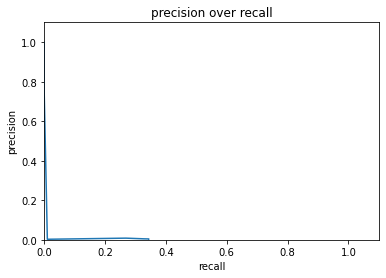

Training started.


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([32, 30, 10, 10])


  1%|▏         | 1/67 [02:10<2:23:44, 130.68s/it]

torch.Size([32, 30, 10, 10])


  3%|▎         | 2/67 [04:13<2:16:23, 125.89s/it]

torch.Size([32, 30, 10, 10])


  4%|▍         | 3/67 [06:18<2:14:12, 125.82s/it]

torch.Size([32, 30, 10, 10])


  6%|▌         | 4/67 [08:21<2:10:38, 124.41s/it]

torch.Size([32, 30, 10, 10])


  7%|▋         | 5/67 [10:28<2:09:27, 125.28s/it]

torch.Size([32, 30, 10, 10])


  9%|▉         | 6/67 [12:38<2:09:19, 127.21s/it]

torch.Size([32, 30, 10, 10])


 10%|█         | 7/67 [14:57<2:10:49, 130.82s/it]

torch.Size([32, 30, 10, 10])


 12%|█▏        | 8/67 [17:08<2:08:37, 130.81s/it]

torch.Size([32, 30, 10, 10])


 13%|█▎        | 9/67 [19:13<2:04:57, 129.26s/it]

torch.Size([32, 30, 10, 10])


 15%|█▍        | 10/67 [21:25<2:03:28, 129.97s/it]

torch.Size([32, 30, 10, 10])


 16%|█▋        | 11/67 [23:33<2:00:53, 129.53s/it]

torch.Size([32, 30, 10, 10])


 18%|█▊        | 12/67 [26:18<2:08:36, 140.29s/it]

torch.Size([32, 30, 10, 10])


 19%|█▉        | 13/67 [28:23<2:02:00, 135.56s/it]

torch.Size([32, 30, 10, 10])


In [ ]:
NUM_TEST_SAMPLES = 30
NUM_EPOCHS = 20
test_AP = []
num_iterations = 20
ratio = 0.1

for iteration in range(num_iterations):
    print(f"-----Pruning iteration {iteration+1}/{num_iterations}-----")
    state_dict = l1_structured_pruning(net.cpu().state_dict(), ratio)
    state_dict = densify_state_dict(state_dict)
    net.load_state_dict(state_dict)
    print(f"Pruning done.")
    
    for epoch in range(NUM_EPOCHS):
        if epoch >= 0:
            net.train()
            net.to(device)
            print("Training started.")
            for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
                input, target = input.to(device), target.to(device)
                optimizer.zero_grad()
                #Yolo head is implemented in the loss for training, therefore yolo=False
                output = net(input, yolo=False)
                loss, _ = criterion(output, target)
                loss.backward()
                optimizer.step()
            
        test_precision = []
        test_recall = []
        net.eval()
        print("Validation started.")
        with torch.no_grad():
            for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
                input, target = input.to(device), target.to(device)
                output = net(input, yolo=True)
        
                #The right threshold values can be adjusted for the target application
                output = filter_boxes(output, 0.0)
                output = nms(output, 0.5)
        
                precision, recall = precision_recall_levels(target[0], output[0])
                test_precision.append(precision)
                test_recall.append(recall)
                if idx == NUM_TEST_SAMPLES:
                    break
                
        #Calculation of average precision with collected samples
        test_AP.append(ap(test_precision, test_recall))
        print('average precision', test_AP)

        #plot ROC
        display_roc(test_precision, test_recall)
    

In [ ]:
torch.save(state_dict, 'pruned_tinyyolov2NoBN.pt')